# PROYEK KEDUA
### MEMBUAT MODEL MACHINE LEARNING DENGAN DATA TIME SERIES
Disusun Oleh: Muchammad Malik

Notes:
1. Dataset diambil dari Kaggle, pada tanggal 13 Juli 2021, dengan link: https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data
2. File dataset dalam bentuk csv, yang berjudul DailyDelhiClimateTrain.csv
3. File dataset sudah berada dalam folder zip yang sama
4. Range data berkisar antara 6,00 - 38,71. Persyaratan error 10% tercapai ketika mae = 3.271
5. error terkecil saat percobaan terakhir yaitu mae = 1,7968

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [16]:
data = pd.read_csv('DailyDelhiClimateTrain.csv')
data

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [17]:
data.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


Data yang dipilih: meantemp

Range data  = 38.71 - 6.00 = 32.71

mae 10% = 3.27

In [18]:
data.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Text(0.5, 1.0, 'Daily Climate')

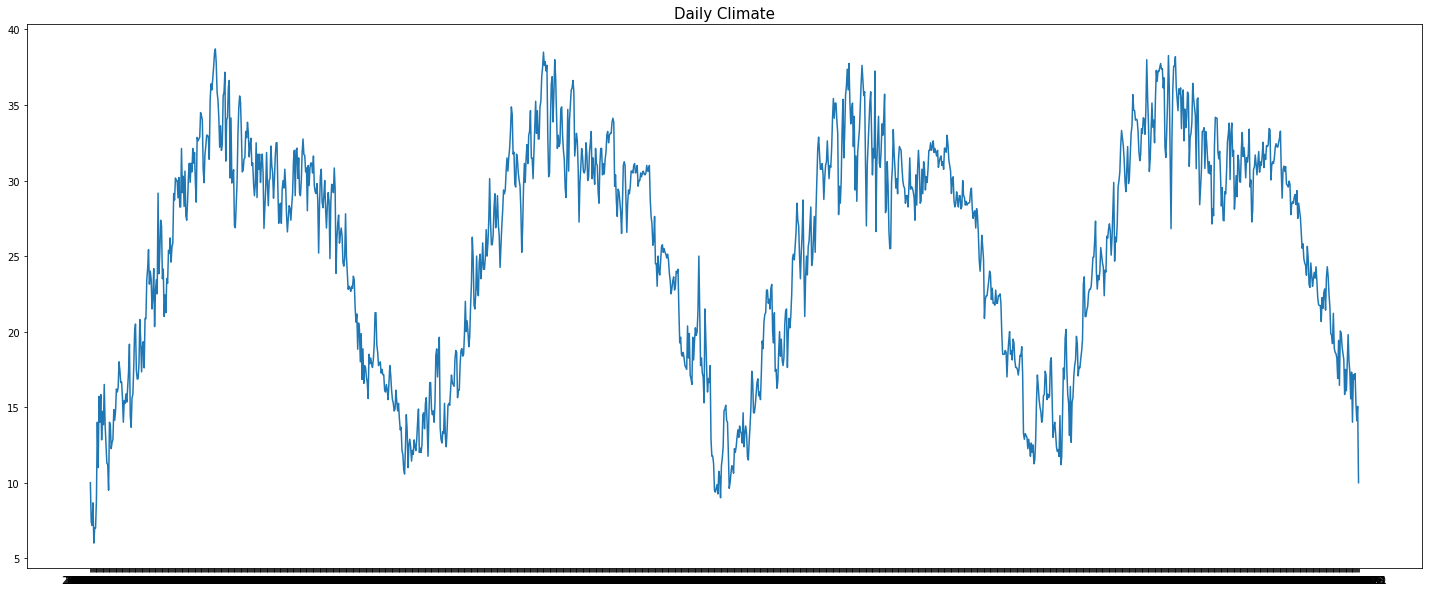

In [22]:
dates = data['date'].values
climate = data['meantemp'].values

plt.figure(figsize=(25,10))
plt.plot(dates,climate)
plt.title('Daily Climate', fontsize=15)

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dates, climate, test_size = 0.2, random_state = 0 , shuffle=False) 
#pemisahan data time series tidak boleh dijadikan random, sehingga shuffle bernilai false

In [24]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

trainset = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=1000)
valset = windowed_dataset(y_test, window_size=60, batch_size=100, shuffle_buffer=1000)

In [28]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

sgd = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=sgd,
              metrics=["mae"])

#menghentikan training ketika akurasi mencapai 95% dengan callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):   
    if(logs.get('mae')<1.8):
      print("\nError dibawah 1,8")      
      self.model.stop_training = True
callbacks = myCallback()

num_epochs = 150
history = model.fit(trainset,                     
                    epochs=num_epochs, 
                    validation_data=(valset),                    
                    verbose = 1,
                    callbacks = [callbacks])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
12/12 [==============================] - 6s 189ms/step - loss: 24.4063 - mae: 24.9063 - val_loss: 27.9336 - val_mae: 28.4336
Epoch 2/150
12/12 [==============================] - 2s 114ms/step - loss: 24.2248 - mae: 24.7248 - val_loss: 27.7055 - val_mae: 28.2055
Epoch 3/150
12/12 [==============================] - 2s 113ms/step - loss: 23.9992 - mae: 24.4992 - val_loss: 27.4687 - val_mae: 27.9687
Epoch 4/150
12/12 [==============================] - 2s 111ms/step - loss: 23.7800 - mae: 24.2800 - val_loss: 27.2508 - val_mae: 27.7508
Epoch 5/150
12/12 [==============================] - 2s 116ms/step - loss: 23.5637 - mae: 24.0637 - val_loss: 27.0211 - val_mae: 27.5211
Epoch 6/150
12/12 [==============================] - 2s 113ms/step - loss: 23.3375 - mae: 23.8375 - val_loss: 26.7869 - val_mae: 27.2869
Epoch 7/150
12/12 [==============================] - 2s 114ms/step - loss: 23.1042 - mae: 23.6042 - val_loss: 26.5424 - val_mae: 27.0424
Epoch 8/150
12/12 [======================

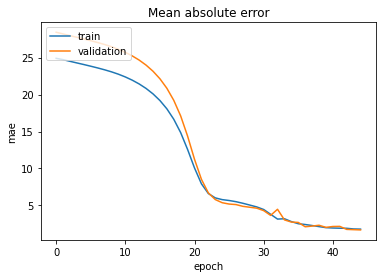

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean absolute error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()